In [1]:
# Get all Title Tuesday results over last year
import requests
import requests
from bs4 import BeautifulSoup
import re

links = []
for each in range(10):

    r = requests.get(f'https://www.chess.com/tournament/live/titled-tuesdays?&page={each}')
    soup = BeautifulSoup(r.content, 'html.parser')
    elements = soup.find_all('a',class_='tournaments-live-name')
    for every in elements:
        link  = every.get('href')
        links.append(link)
ids = [each.split('/')[-1] for each in links]


In [2]:
import requests
import pandas as pd
import tqdm

def get_game(id):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    response = requests.get(f'https://api.chess.com/pub/tournament/{id}', headers=headers)
    game = response.json()
    return game

def single_tournament(game):
    df = pd.DataFrame(game['players'])
    df['position'] = range(1, len(df) + 1)
    df['date'] = game['finish_time']
    return df

dfs = []
for each in tqdm.tqdm(ids):
    game = get_game(each)
    df = single_tournament(game)
    dfs.append(df)

# Concatenate DataFrames vertically
final_df = pd.concat(dfs, ignore_index=True)


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


In [3]:
transformed = final_df.groupby('username').agg({'position':'mean', 'date':'count'}).reset_index().sort_values('position')
best_titled_players = transformed.loc[transformed.date > 1].username.values


In [9]:
player = 'magnuscarlsen'

def get_titled_tournaments_player(player):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    response = requests.get(f'https://api.chess.com/pub/player/{player}/tournaments', headers=headers).json()
    return response
def players_perfomance(tournaments):
    placements = []
    for each in tournaments['finished']:
        if ('late-titled' in each['@id']) | ('early-titled' in each['@id']):
            try:
                placements.append({'id': each['@id'], 'place': each['placement']})
            except:
                pass
    df = pd.DataFrame(placements)
    df['player'] = player
    df = df.loc[df.place< 200]

    return df

tournaments = get_titled_tournaments_player(player)
df = players_perfomance(tournaments)


In [10]:
results_df = []
for player in tqdm.tqdm(best_titled_players):
    tournaments = get_titled_tournaments_player(player)
    df = players_perfomance(tournaments)
    results_df.append(df)


100%|██████████| 387/387 [02:15<00:00,  2.85it/s]


In [11]:
final_results_df = pd.concat(results_df, ignore_index=True)
over_30_games_players = final_results_df.groupby('player').agg({'id':'count'}).reset_index().query('id > 30').player.values
over_30_games_players_df = final_results_df.loc[final_results_df['player'].isin(over_30_games_players)]


In [12]:
def get_name(player):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    response = requests.get(f' https://api.chess.com/pub/player/{player}', headers=headers).json()
    return response

player_names = []
for player in tqdm.tqdm(over_30_games_players):
    try:
        name = get_name(player)['name']
        player_names.append({'player':player, 'name':name})
    except:
        pass


100%|██████████| 133/133 [00:43<00:00,  3.03it/s]


In [13]:
player_names
#TODO
# Create API to check players FIDE ratings


[{'player': 'abund', 'name': 'Yuan, Qingyu'},
 {'player': 'actorxu', 'name': 'Xu Yi'},
 {'player': 'alexei_gubajdullin', 'name': 'Alexei Gubajdullin'},
 {'player': 'alexpapasimakopoulos', 'name': 'Alexandros Papasimakopoulos'},
 {'player': 'alexrustemov', 'name': 'Alexander Rustemov'},
 {'player': 'anton_demchenko', 'name': 'Anton Demchenko'},
 {'player': 'aradhya2000', 'name': 'Aradhya Garg'},
 {'player': 'artin10862', 'name': 'Artin Ashraf'},
 {'player': 'aryantari', 'name': 'Aryan Tari'},
 {'player': 'arystanner', 'name': 'Arystanbek Urazayev'},
 {'player': 'atbenina64', 'name': 'Abtin Atakhan'},
 {'player': 'attack2mateu', 'name': 'Razvan Preotu'},
 {'player': 'avitalbor', 'name': 'Avital Boruchovsky'},
 {'player': 'aygehovit1992', 'name': 'Nikita Matinian'},
 {'player': 'baki83', 'name': 'Etienne Bacrot'},
 {'player': 'bazar-wokzal', 'name': 'Nikolai Vlassov'},
 {'player': 'beanscreen', 'name': 'Zachary Tanenbaum'},
 {'player': 'beca95', 'name': 'Aleksandar Indjic'},
 {'player': '

In [27]:
import requests
from bs4 import BeautifulSoup

# Function to extract Blitz rating
def get_blitz_rating(divs):
    for div in divs:
        label = div.find("div", class_="stats-label").text
        if label.lower() == "blitz":
            return div.find("div", class_="stats-value").text
    return "Blitz rating not found"

def check_rating(name):
    splitted_name = name.split(' ')
    lowercased = [each.lower() for each in splitted_name]
    joined_name = '-'.join(lowercased)
    url= f'https://www.chess.com/players/{joined_name}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    all_stats = soup.find_all('div', class_='stats-info')

    return get_blitz_rating(all_stats)


In [44]:
import time
for player in tqdm.tqdm(player_names):
    iterations=0
    name = player['name']
    rating = check_rating(name)
    while (rating == 'Blitz rating not found') & (iterations <= 3):
        time.sleep(3)
        iterations+=1
        rating = check_rating(name)
    player.update({'rating':rating})


100%|██████████| 131/131 [17:02<00:00,  7.80s/it]


In [41]:
name
check_rating(name)


'Blitz rating not found'

In [50]:
fide_df = pd.DataFrame(player_names)
# fide_df.to_csv('players_ratings.csv', index=False)
rating_players = fide_df.loc[fide_df.rating!='Blitz rating not found'].astype({'rating':int})


In [51]:
import numpy as np
import matplotlib.pyplot as plt
def ecdf(data):
  """Compute ECDF for a one-dimensional array of measurements."""

  # Number of data points: n
  n = len(data)

  # x-data for the ECDF: x
  x = np.sort(data)

  # y-data for the ECDF: y
  y = np.arange(1, n+1) / n

  return x, y

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))

    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw `size` bootstrap replicates."""
    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def plugin_summary(
    data, func, ptiles=(2.5, 97.5), n_bs_reps=2000, label=None
):
    """Compute and store ECDF, plug-in estimate, and confidence
    intervals in a dictionary."""
    # Initialize output dictionary
    summary = {}
    # Store data and settings
    summary['data'] = data
    summary['func'] = func
    summary['ptiles'] = ptiles
    summary['n_bs_reps'] = n_bs_reps
    summary['label'] = label
    # Compute ECDF x and y values
    summary['ecdf_x'], summary['ecdf_y'] = ecdf(data)
    # Compute plug-in estimate
    summary['estimate'] = func(data)
    # Compute bootstrap confidence interval
    summary['bs_reps'] = draw_bs_reps(data, func, size=n_bs_reps)
    summary['conf_int'] = np.percentile(summary['bs_reps'], ptiles)
    return summary

def plot_conf_ints(summaries, palette=None):
    """Plot confidence intervals with estimates."""
    # Set a nice color palette
    if palette is None:
        palette = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
    elif type(palette) == str:
        palette = [palette]

    labels = [ci["label"] for ci in summaries][::-1]
    estimates = [ci["estimate"] for ci in summaries][::-1]
    conf_intervals = [ci["conf_int"] for ci in summaries][::-1]
    palette = palette[: len(labels)][::-1]

    # Set up axes for plot
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot estimates as dots and confidence intervals as lines
    for i, (label, est, conf_int) in enumerate(
        zip(labels, estimates, conf_intervals)
    ):
        color = palette[i % len(palette)]
        ax.plot(
            [est],
            [label],
            marker=".",
            linestyle="none",
            markersize=10,
            color=color,
        )

        ax.plot(conf_int, [label] * 2, linewidth=3, color=color)

    # Make sure margins look ok
    ax.margins(y=0.25 if len(labels) < 3 else 0.125)

    return ax


In [54]:
rating_players


,player,name,rating
1,actorxu,Xu Yi,2460
2,alexei_gubajdullin,Alexei Gubajdullin,2275
3,alexpapasimakopoulos,Alexandros Papasimakopoulos,2358
5,anton_demchenko,Anton Demchenko,2545
7,artin10862,Artin Ashraf,2224
...,...,...,...
124,vugarrasulov,Vugar Rasulov,2517
125,vuk2000,Vuk Djordjevic,2425
127,wonderfultime,Tuan Minh Le,2565
128,wpwpwp-2015,Wojciech Przybylski,2228


In [56]:
slice = over_30_games_players_df.loc[over_30_games_players_df.player.isin(rating_players.player.values)]


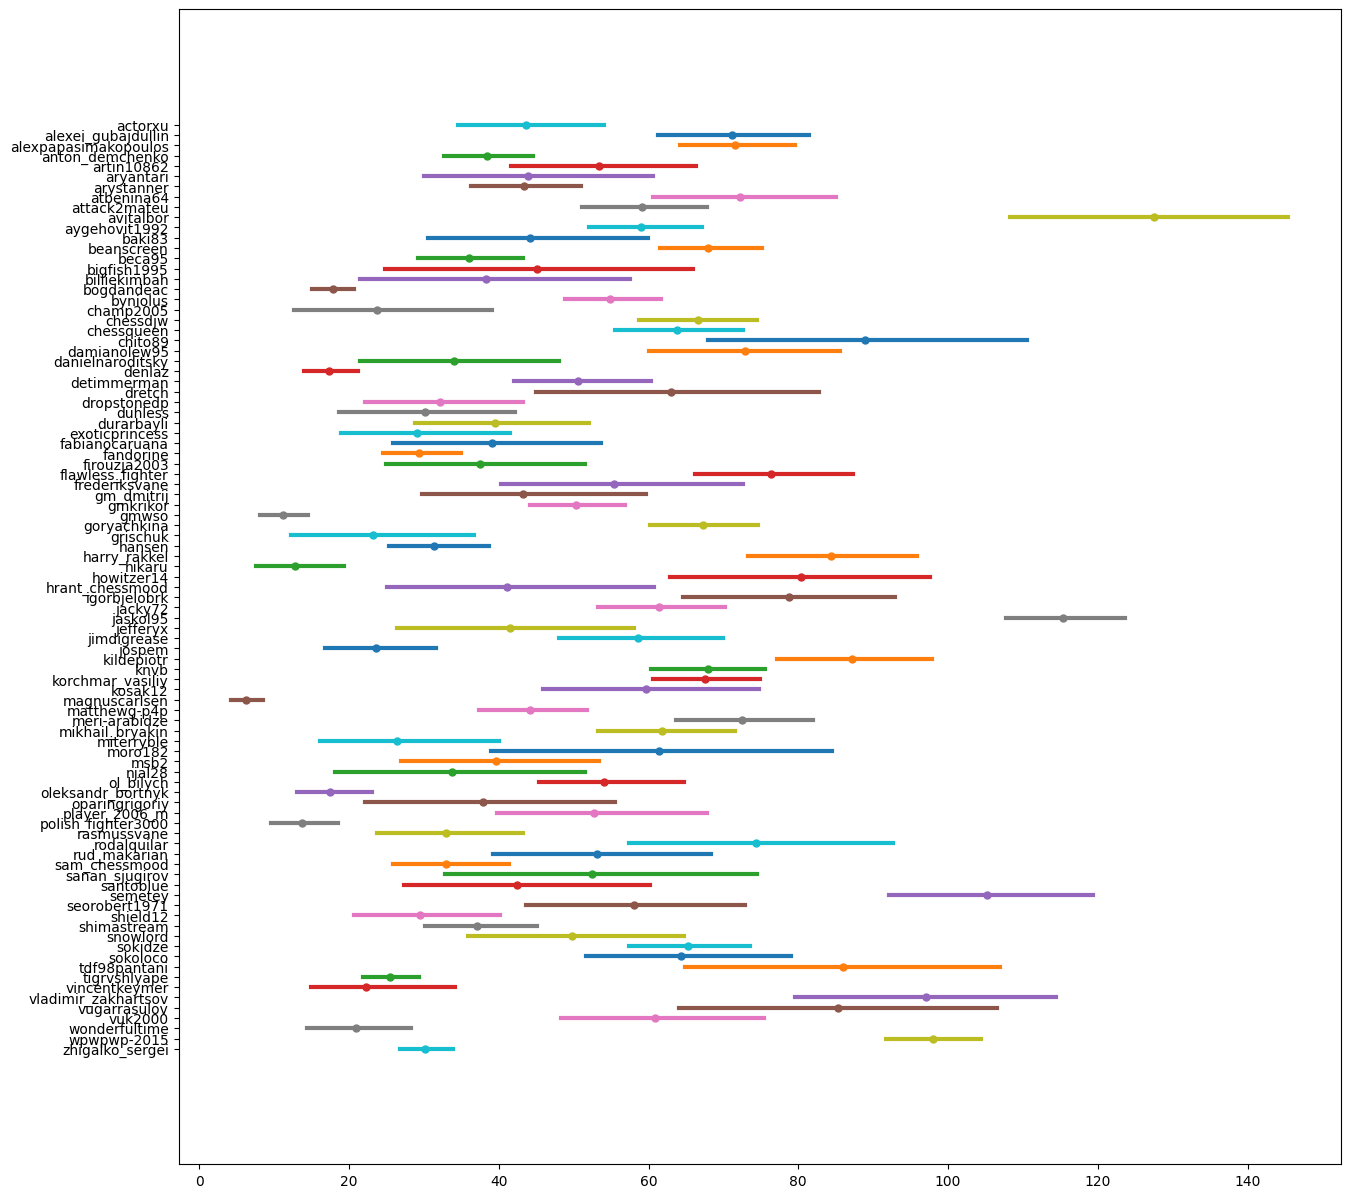

In [57]:
# Initialize list of plug-in summaries
summaries = []
# Iterate through groups and instantiate conf intervals
for label, group in slice.groupby('player'):
    summaries.append(
      plugin_summary(
          group['place'].dropna().values, np.mean, label=label
      )
  )
fig = plot_conf_ints(summaries)


In [59]:
summaries[0]


{'data': array([ 66,  42,  74,  60,  25,  54,  11,  13,  38,  16, 111,  25,  14,
         26,  71,  52,   9,  44,  12,  84,  19,  25,  20,  26,  19,  52,
        101,  15,  17,  19,  45, 127,  29,  83,  17,  12,  23,  22,  70,
         31,  28, 198,  49,  52,  61,  12,  18,  68,  20,  19,  15,  11,
          7, 116, 107]),
 'func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'ptiles': (2.5, 97.5),
 'n_bs_reps': 2000,
 'label': 'actorxu',
 'ecdf_x': array([  7,   9,  11,  11,  12,  12,  12,  13,  14,  15,  15,  16,  17,
         17,  18,  19,  19,  19,  19,  20,  20,  22,  23,  25,  25,  25,
         26,  26,  28,  29,  31,  38,  42,  44,  45,  49,  52,  52,  52,
         54,  60,  61,  66,  68,  70,  71,  74,  83,  84, 101, 107, 111,
        116, 127, 198]),
 'ecdf_y': array([0.01818182, 0.03636364, 0.05454545, 0.07272727, 0.09090909,
        0.10909091, 0.12727273, 0.14545455, 0.16363636, 0.18181818,
        0.2       , 0.21818

In [61]:
summaries_stats = []
for each in summaries:
    name = each['label']
    num_games = len(each['data'])
    estimate = each['estimate']
    min_int = each['conf_int'][0]
    max_int = each['conf_int'][1]
    summaries_stats.append({'name':name, 'num_games':num_games, 'estimate':estimate, 'min_int':min_int, 'max_int': max_int})


In [64]:
rating_players


,player,name,rating
1,actorxu,Xu Yi,2460
2,alexei_gubajdullin,Alexei Gubajdullin,2275
3,alexpapasimakopoulos,Alexandros Papasimakopoulos,2358
5,anton_demchenko,Anton Demchenko,2545
7,artin10862,Artin Ashraf,2224
...,...,...,...
124,vugarrasulov,Vugar Rasulov,2517
125,vuk2000,Vuk Djordjevic,2425
127,wonderfultime,Tuan Minh Le,2565
128,wpwpwp-2015,Wojciech Przybylski,2228


In [68]:
summaries_stats_df = pd.DataFrame(summaries_stats)
merged_df =pd.merge(summaries_stats_df, rating_players, how='left',left_on='name', right_on='player', left_index=False, right_index=False)
merged_df=merged_df.drop(columns=['name_x','player'])


In [79]:
merged_df['conf_width'] = merged_df['max_int'] - merged_df['min_int']
merged_df.sort_values('estimate').head(20)


,num_games,estimate,min_int,max_int,name_y,rating,conf_width
56,36,6.222222,4.304861,8.528472,Magnus Carlsen,2887,4.223611
38,31,11.193548,8.161290,14.484677,Wesley So,2760,6.323387
43,121,12.776860,7.527893,19.380579,Hikaru Nakamura,2874,11.852686
68,49,13.673469,9.591327,18.532143,Jan-Krzysztof Duda,2775,8.940816
24,69,17.362319,13.956522,21.188768,Denis Lazavik,2560,7.232246
65,137,17.452555,13.109124,23.037044,Oleksandr Bortnyk,2725,9.927920
16,95,17.810526,15.115789,20.663684,Bogdan Daniel Deac,2641,5.547895
88,57,20.912281,14.366667,28.315789,Tuan Minh Le,2565,13.949123
84,32,22.281250,14.906250,34.187500,Vincent Keymer,2645,19.281250
40,38,23.157895,12.288816,36.710526,Alexander Grischuk,2701,24.421711


/Users/poloniki/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/poloniki/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/poloniki/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/poloniki/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

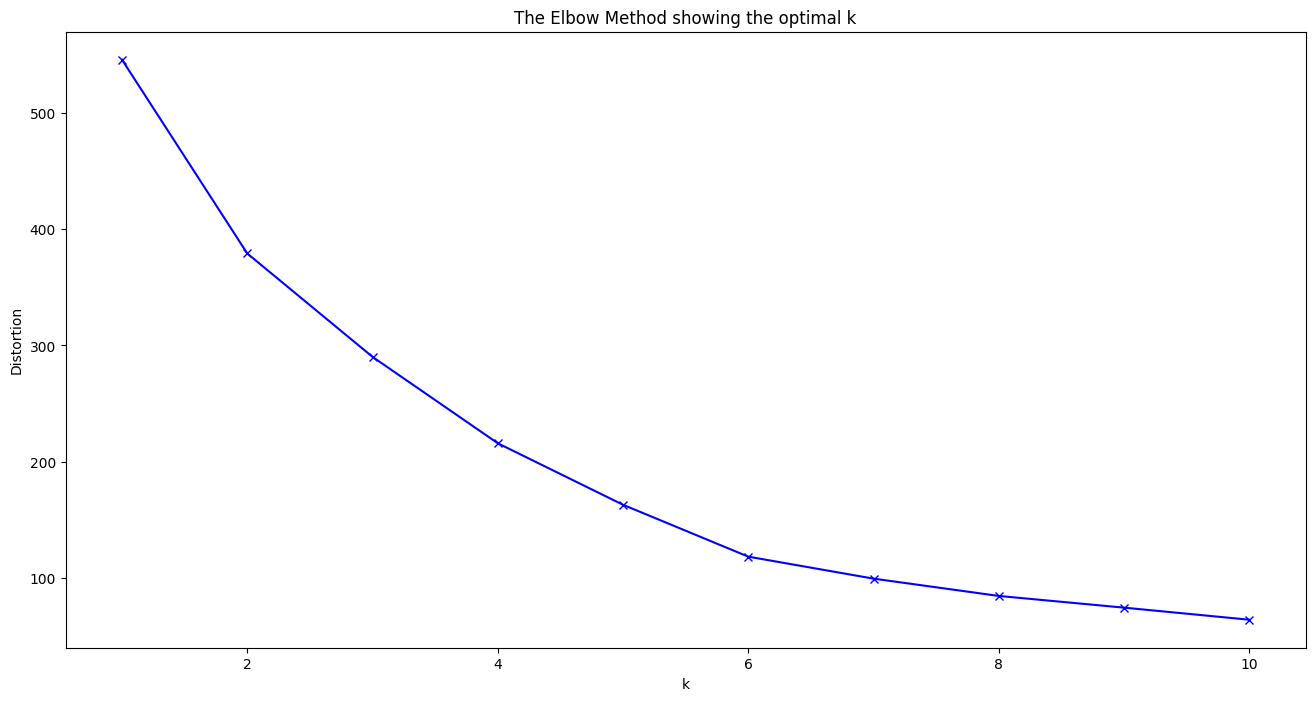

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Assuming merged_df is your dataframe and it's already been loaded
X = merged_df.drop(columns=['name_y', 'min_int', 'max_int', 'num_games'])

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    distortions.append(kmeanModel.inertia_)

# Now you can plot the distortions to find the elbow point
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [168]:
kmeanModel = KMeans(n_clusters=6)
kmeanModel.fit(X)


/Users/poloniki/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=6)

In [169]:
merged_df['cluster'] = kmeanModel.labels_


In [170]:
merged_df = merged_df.sort_values('conf_width')


In [171]:
# Function to categorize ratings
def categorize_rating(rating):
    if rating < 2000:
        return 'Below 2000'
    else:
        return str((rating // 50) * 50)

# Apply function to create new categorical feature
merged_df['rating_cat'] = merged_df['rating'].apply(categorize_rating)


In [177]:
import plotly.express as px
import pandas as pd


# Creating a 3D scatter plot
fig = px.scatter_3d(merged_df, x='estimate', y='cluster', z='conf_width', color='rating_cat',hover_name='name_y')

# Showing the plot
fig.show()


In [174]:
merged_df.head(40)


,num_games,estimate,min_int,max_int,name_y,rating,conf_width,cluster,rating_cat,new_cluster
56,36,6.222222,4.304861,8.528472,Magnus Carlsen,2887,4.223611,5,2850,-1
16,95,17.810526,15.115789,20.663684,Bogdan Daniel Deac,2641,5.547895,2,2600,-1
38,31,11.193548,8.161290,14.484677,Wesley So,2760,6.323387,1,2750,-1
90,163,30.184049,26.754448,33.871626,Sergei Zhigalko,2616,7.117178,2,2600,-1
24,69,17.362319,13.956522,21.188768,Denis Lazavik,2560,7.232246,2,2550,-1
83,154,25.525974,21.934903,29.370292,Gata Kamsky,2660,7.435390,1,2650,-1
68,49,13.673469,9.591327,18.532143,Jan-Krzysztof Duda,2775,8.940816,1,2750,-1
65,137,17.452555,13.109124,23.037044,Oleksandr Bortnyk,2725,9.927920,1,2700,-1
32,95,29.410526,24.578421,35.021053,Maksim Chigaev,2561,10.442632,2,2550,-1
43,121,12.776860,7.527893,19.380579,Hikaru Nakamura,2874,11.852686,5,2850,-1
